#数据挖掘互评作业四：离群点分析与异常检测#
##数据集：skin##

##1、导入并展示数据## 

首先以一个文件为例导入并展示文件
数据集说明：
该数据集共包括9列，其中original.label为原始数据的类标签；
ground.truth取值为nominal表示正常点，anomaly表示异常点
后3列为分类预测所使用的特征

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score,auc,roc_curve
from sklearn.model_selection import train_test_split 
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
#导入数据
data = pd.read_csv('./skin/benchmarks/skin_benchmark_0001.csv')
print('数据行数:'+str(data.shape[0]))
print('数据列数:'+str(data.shape[1]))
print("每个变量数据类型:")
print(data.dtypes)
print("数据前五行:")
data.head()

数据行数:6000
数据列数:9
每个变量数据类型:
point.id           object
motherset          object
origin             object
original.label      int64
diff.score        float64
ground.truth       object
R                 float64
G                 float64
B                 float64
dtype: object
数据前五行:


,point.id,motherset,origin,original.label,diff.score,ground.truth,R,G,B
0,skin_point_117027,skin,binary,2,0.020405,nominal,-1.864336,-2.110524,-1.587289
1,skin_point_016927,skin,binary,1,0.000250,anomaly,0.384456,0.925785,1.747782
2,skin_point_240995,skin,binary,2,0.001285,nominal,-0.980882,-1.092860,-1.394351
3,skin_point_018861,skin,binary,1,0.000739,anomaly,-1.125447,-0.542320,0.383435
4,skin_point_087883,skin,binary,2,0.001053,nominal,-0.964819,-1.076177,-1.380570


数据集中正常点和异常点的样本数：

In [3]:
data['ground.truth'].value_counts()

nominal    4783
anomaly    1217
Name: ground.truth, dtype: int64

提取original.label、R、G、B这四个特征后续的的离群点分类预测

In [5]:
x = data[['original.label','R','G','B']]
x.head()

,original.label,R,G,B
0,2,-1.864336,-2.110524,-1.587289
1,1,0.384456,0.925785,1.747782
2,2,-0.980882,-1.092860,-1.394351
3,1,-1.125447,-0.542320,0.383435
4,2,-0.964819,-1.076177,-1.380570


将ground.truth这一列划分为0和1,0代表正常点，1代表异常点，作为类标签

In [6]:
y = data[['ground.truth']]
y['ground.truth']=np.where(y['ground.truth']=='anomaly',1,0)
y = y['ground.truth'].values

##2、离群点预测##
现在读入全部benchmark数据文件，使用Cluster-based Local Outiler Factor、Feature Bagging、
Histogram-base Outlier Detection(HBOS)、Isolation Forest、KNN、Average KNN这六种分类器进行离群点分类预测，
并采用auc取平均作为评估指标

In [1]:
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
classifiers = ["Cluster-based Local Outiler Factor (CBLOF)","Feature Bagging","Histogram-base Outlier Detection(HBOS)",\
              "Isolation Forest","KNN","Average KNN"]
auc_score = {}
for clf_name in classifiers:
    auc_score[clf_name] = []

In [8]:
##输入全部skin-benchmarks数据集进行离群点预测
path_in = './skin/benchmarks/'
files = os.listdir(path_in)
for file in files:
    filename = path_in+file
    data = pd.read_csv(filename) ##读入数据
    ##提取特征x和类标签y
    x = data[['original.label','R','G','B']]
    y = data[['ground.truth']]
    y['ground.truth']=np.where(y['ground.truth']=='anomaly',1,0)
    y = y['ground.truth'].values
    ##划分测试集和训练集
    x_train,x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=0)
        
    ##定义分类器
    outliers_fraction = data['ground.truth'].value_counts()['anomaly'] / len(data)  ##异常点比例
    classifiers = {
        "Cluster-based Local Outiler Factor (CBLOF)": CBLOF(contamination = outliers_fraction,check_estimator=False),
        "Feature Bagging" : FeatureBagging(LOF(n_neighbors=50),contamination=outliers_fraction,check_estimator=False),
        "Histogram-base Outlier Detection(HBOS)" : HBOS(contamination=outliers_fraction),
        "Isolation Forest" :IForest(contamination=outliers_fraction),
        "KNN" : KNN(contamination=outliers_fraction),
        "Average KNN" :KNN(method='mean',contamination=outliers_fraction)
    }
    ##初始化auc
    ##分类预测
    for i ,(clf_name,clf) in enumerate(classifiers.items()):
        clf.fit(x_train)
        # 预测离群得分
        scores_pred = clf.decision_function(x_test)
        fpr, tpr, thresholds = roc_curve(y_test, scores_pred, pos_label=1)
        auc_score[clf_name].append(auc(fpr,tpr))

In [9]:
##计算auc平均值
result = {}
for clf in auc_score.keys():
    sum = 0
    for item in auc_score[clf]:
        sum += item
    sum /= len(auc_score[clf])
    result[clf] = sum

##3、结果可视化##

In [10]:
df = pd.DataFrame.from_dict(result, orient='index',columns=['auc'])
df = df.reset_index().rename(columns = {'index':'id'})
df

,id,auc
0,Cluster-based Local Outiler Factor (CBLOF),0.827592
1,Feature Bagging,0.701018
2,Histogram-base Outlier Detection(HBOS),0.997868
3,Isolation Forest,0.975908
4,KNN,0.739336
5,Average KNN,0.730580


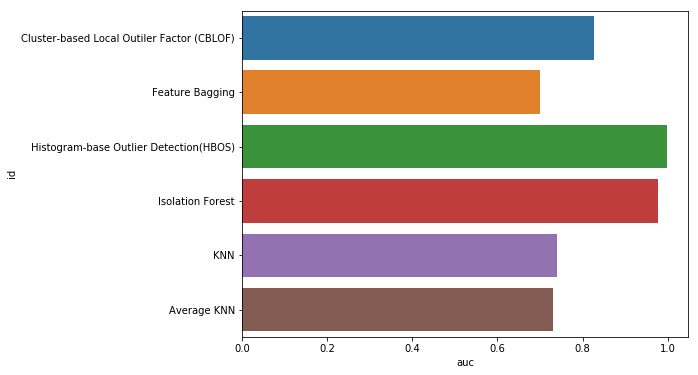

In [11]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(y=df.id,x='auc',data=df)

##4、结果分析##
通过输出的结果和可视化分析可以看出，六种分类器中Histogram-base Outlier Detection(HBOS)的预测效果最好，auc达到了0.99；
其次是Isolation Fores，auc为0.98；
之后是Cluster-based Local Outiler Factor (CBLOF)，auc为0.83；
而Feature Bagging、KNN和Average KNN的预测效果最差，auc得分在0.7-0.75之间。